# Tuberculosis classification from chest X-ray
<a target="_blank" href="https://colab.research.google.com/github/SrjPdl/tuberculosis-classification/TB_detection.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Papers
- [Reliable Tuberculosis Detection Using Chest X-Ray With Deep Learning, Segmentation and Visualization](https://ieeexplore.ieee.org/document/9224622)
- [Deep learning-based automatic detection of tuberculosis disease in chest X-ray images](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8906182/)
### Chexnet (used for transfer learning)
- [CheXNet: Radiologist-Level Pneumonia Detection on Chest X-Rays with Deep Learning](https://paperswithcode.com/paper/chexnet-radiologist-level-pneumonia-detection)

In [ ]:
#download dataset
!gdown 1sZpa8bBFUgPLFJYmU0sqUW6k0500hvYH

Downloading...
From: https://drive.google.com/uc?id=1sZpa8bBFUgPLFJYmU0sqUW6k0500hvYH
To: /content/TB_Chest_Radiography_Database.zip
100% 695M/695M [00:03<00:00, 179MB/s]


In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.1/203.1 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=abb37dd78ed14f7d8d0806fa60ddaf1fc78d957c1e8d3fcfd93e1a14f43da6eb
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
#extract the data
! unzip /content/TB_Chest_Radiography_Database.zip && rm /content/TB_Chest_Radiography_Database.zip

Archive:  /content/TB_Chest_Radiography_Database.zip
   creating: content/gdrive/MyDrive/kaggle/TB_Chest_Radiography_Database/
  inflating: content/gdrive/MyDrive/kaggle/TB_Chest_Radiography_Database/Normal.metadata.xlsx  
  inflating: content/gdrive/MyDrive/kaggle/TB_Chest_Radiography_Database/README.md.txt  
  inflating: content/gdrive/MyDrive/kaggle/TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx  
   creating: content/gdrive/MyDrive/kaggle/TB_Chest_Radiography_Database/Normal/
  inflating: content/gdrive/MyDrive/kaggle/TB_Chest_Radiography_Database/Normal/Normal-3372.png  
  inflating: content/gdrive/MyDrive/kaggle/TB_Chest_Radiography_Database/Normal/Normal-3274.png  
  inflating: content/gdrive/MyDrive/kaggle/TB_Chest_Radiography_Database/Normal/Normal-335.png  
  inflating: content/gdrive/MyDrive/kaggle/TB_Chest_Radiography_Database/Normal/Normal-3366.png  
  inflating: content/gdrive/MyDrive/kaggle/TB_Chest_Radiography_Database/Normal/Normal-3357.png  
  inflating: con

In [ ]:
#system imports
import os
from tqdm.notebook import tqdm

# numpy and pandas imports
import numpy as np
from numpy.random import seed
import pandas as pd

#visualization imports
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#tensorflow imports
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.utils import resample


#wandb imports (for experiement tracking)
import wandb
from wandb.keras import WandbMetricsLogger

In [ ]:
#get a list of available GPU's
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [ ]:
DATASET_PATH = r"/content/content/gdrive/MyDrive/kaggle/TB_Chest_Radiography_Database"
NORMAL_DATA_PATH = os.path.join(DATASET_PATH, "Normal")
TUBERCULOSIS_DATA_PATH = os.path.join(DATASET_PATH, "Tuberculosis")

BATCH_SIZE = 64
SEED = 56

#Data Augmentation Parameters
RESCALE = 1./255
ROTATION_RANGE = 10
WIDTH_SHIFT_RANGE = 0.1
HEIGHT_SHIFT_RANGE = 0.1
ZOOM_RANGE = 0.1
HORIZONTAL_FLIP = True

TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.2 

# set seed for reproducibilty of results
seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# count the number of data samples belonging to each class and make a dataframe
# consisting of class_name and file_path

labels_count = {"Normal": 0, "Tuberculosis": 0}
file_list = []
files = os.listdir(NORMAL_DATA_PATH)

for file in tqdm(files, desc="Normal class"):
    labels_count["Normal"] += 1
    file_path = os.path.join(NORMAL_DATA_PATH, file)
    class_name = os.path.basename(os.path.dirname(file_path))
    file_list.append([file_path, class_name])

files = os.listdir(TUBERCULOSIS_DATA_PATH)
for file in tqdm(files, desc="Tuberculosis class"):
    labels_count["Tuberculosis"] += 1
    file_path = os.path.join(TUBERCULOSIS_DATA_PATH, file)
    class_name = os.path.basename(os.path.dirname(file_path))
    file_list.append([file_path, class_name]) 

xray_df = pd.DataFrame(file_list, columns=['file_path', 'class_name'])
    
xray_df = xray_df.sample(frac=1, random_state=SEED).reset_index(drop=True)

Normal class:   0%|          | 0/3500 [00:00<?, ?it/s]

Tuberculosis class:   0%|          | 0/700 [00:00<?, ?it/s]

## Dataset Distribution

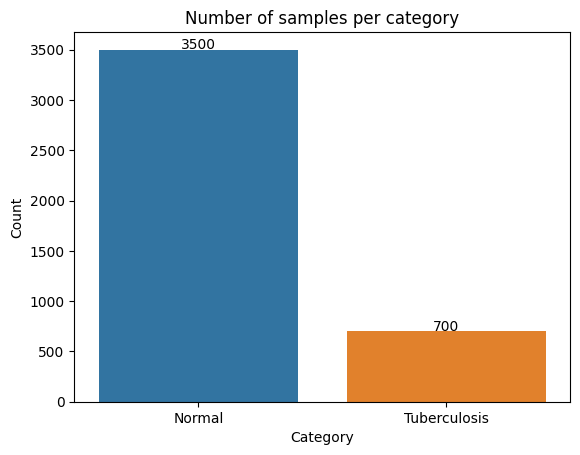

In [ ]:
# plot amount of data samples in each class
sns.barplot(x=list(labels_count.keys()), y=list(labels_count.values()))
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Number of samples per category')
for i, v in enumerate(labels_count.values()):
    plt.text(i, v+10, str(v), color='black', ha='center')
plt.show()

From above countplot, we can see data is highly imbalanced with only 700 samples belonging to positive class and 3500 to negative class. So, this must be taken into account while training the model.

## Perform Stratified Sampling
Stratified sampling is performed to ensure that the train set and test set have similar distribution of data for both classes and also to make sure that positive class (which is present in small amount) is included in test set.

In [ ]:
xray_train_df, xray_test_df = train_test_split(xray_df, test_size = TEST_SPLIT, stratify = xray_df['class_name'], random_state = SEED)

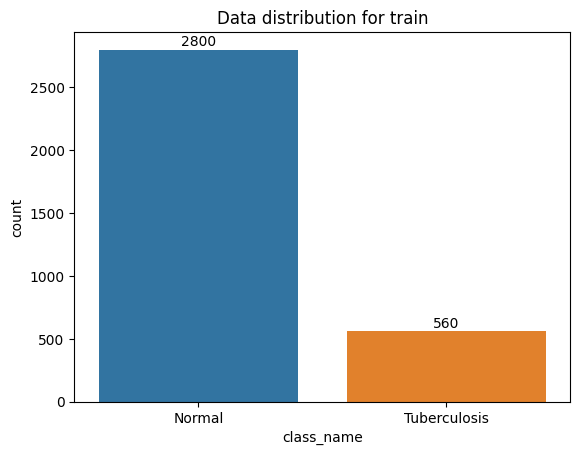

In [ ]:
ax = sns.countplot(xray_train_df, x="class_name", order=xray_test_df['class_name'].value_counts().index)
plt.title("Data distribution for train")
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height() - 50), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

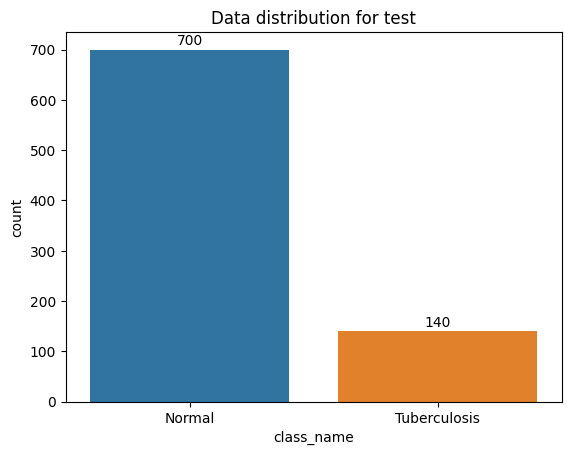

In [ ]:
ax = sns.countplot(xray_test_df, x="class_name", order=xray_test_df['class_name'].value_counts().index)
plt.title("Data distribution for test")
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height() - 10), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

From above two plots, we ca see identical distribution of data for training and test set.

## Plot some example datasets

In [ ]:
#Instantiate image datagenerator
datagen = ImageDataGenerator()
image_data_generator = datagen.flow_from_dataframe(dataframe=xray_train_df,
                                              x_col="file_path",
                                              y_col="class_name",
                                              class_mode="binary",
                                              batch_size=BATCH_SIZE)

Found 3360 validated image filenames belonging to 2 classes.


In [ ]:
# function to plot examples
def plot_examples(image_data_generator):
  """
    Plots examples of images generated by the image_data_generator.

    Args:
    image_data_generator: An instance of the ImageDataGenerator class that generates batches of augmented image data.

    Returns:
    None
  """
  images, labels = image_data_generator.next()
  fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
  for i in range(10):
      row = i // 5
      col = i % 5
      axs[row][col].imshow(images[i][:,:,0], cmap='Greys')
      axs[row][col].set_title('Label: {}'.format(labels[i]))
  plt.tight_layout()
  plt.show()

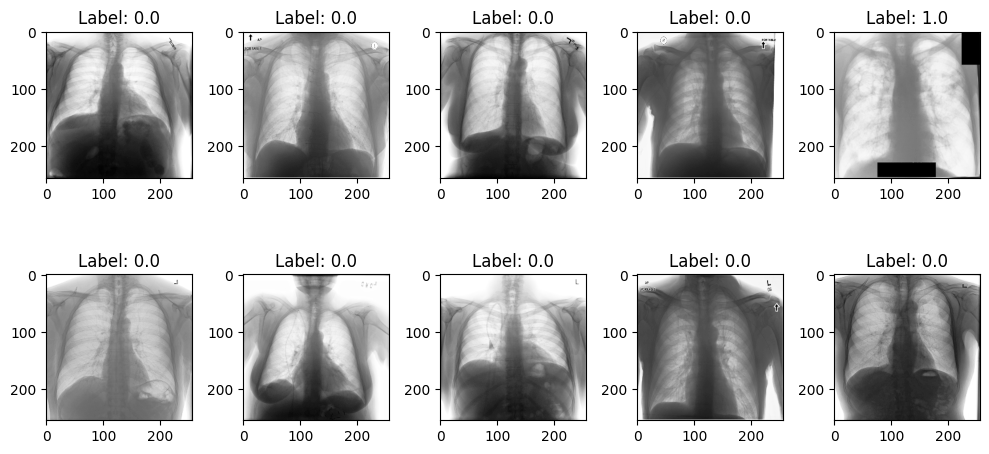

In [ ]:
# run this cell multiple times to get different images as output
plot_examples(image_data_generator)

# CNN Model (model 1)
## Model architecture inspiration taken from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8906182/
![alt text](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8906182/bin/PJR-87-46383-g003.jpg "Title")

## Define Configuration for experiement

In [ ]:
cnn_config = {
    "data": {
        "class_names": ["Normal","Tuberculosis"],
        "image_height": 226,
        "image_width": 226,
        "image_channel": 3,
    },
    "Normalization" : {
        "samplewise_center" : True,
        "samplewise_std_normalization" : True
        
    },
    "augment" : {
        "rotation_range": ROTATION_RANGE,
        "width_shift_range": WIDTH_SHIFT_RANGE,
        "height_shift_range": HEIGHT_SHIFT_RANGE,
        "zoom_range": ZOOM_RANGE,
        "horizontal_flip": HORIZONTAL_FLIP
            },
    "block1": {
        "filters": 32,
        "kernal_size": 3,
        "strides": (1,1),
        "padding": "valid",
        "dropout_rate": 0.2
    },
    "block2": {
        "filters": 64,
        "kernal_size": 3,
        "strides": (1,1),
        "padding": "valid",
        "dropout_rate": 0.2
    },
    "block3" : {
        "filters": 128,
        "kernal_size": 3,
        "strides": (1,1),
        "padding": "valid",
        "dropout_rate": 0.2
            },
    "max_pool" : {
        "pool_size" : (2,2)
    },
    "dense" : {
        "units" : 64,
        "dropout_rate" : 0.2
    },
    "train": {
        "batch_size": BATCH_SIZE,
        "epochs": 50,
        "optimizer": tf.keras.optimizers.Adam,
        "metrics": ['accuracy', 'Precision', 'Recall', 'AUC'],
        "test_split":TEST_SPLIT,
        "valid_split": VALIDATION_SPLIT,
        "lr": 1e-6
    }
}

# Pass the config dictionary while initializing W&B
run = wandb.init(project="tb_classification", config=cnn_config)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
def CNNblock(input, filters, kernal_size, strides, padding, dropout_rate, pool_size, training = False):
  """
      Builds a 3-layer convolutional neural network block with batch normalization,
      max pooling, and dropout layers.

      Args:
          input (tf.Tensor): Input tensor of shape [batch_size, height, width, channels].
          filters (int): Number of filters in each convolutional layer.
          kernal_size (int or tuple): Size of the convolutional kernel.
          strides (int or tuple): Stride of the convolution.
          padding (str): Type of padding to use for convolutional layers.
          activation (str): Activation function to use for convolutional layers.
          dropout_rate (float): Dropout rate to use for dropout layer.
          training (bool): Whether the model is in training mode or not (default: False).

      Returns:
          tf.Tensor: Output tensor of shape [batch_size, height/2, width/2, filters].
          """
  x = tf.keras.layers.Conv2D(
          filters,
          kernal_size,
          strides,
          padding,
          activation = 'relu')(input)
  x = tf.keras.layers.Conv2D(
          filters,
          kernal_size,
          strides,
          padding,
          activation = 'relu')(x)
  x = tf.keras.layers.Conv2D(
          filters,
          kernal_size,
          strides,
          padding,
           activation = 'relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling2D(pool_size)(x)
  x = tf.keras.layers.Dropout(dropout_rate)(x, training=training)
  return x

In [ ]:
def get_cnn_model(config):
  """
  ""Builds a convolutional neural network (CNN) model based on the given configuration.

    Args:
        config (dict): A dictionary containing the configuration parameters for the model.

    Returns:
        tf.keras.Model: A compiled CNN model with the specified architecture and hyperparameters.
  """
  input = tf.keras.layers.Input((config['data']['image_width'], config['data']['image_height'], config['data']['image_channel']))
  x = CNNblock(input, config['block1']['filters'], config['block1']['kernal_size'], config['block1']['strides'], config['block1']['padding'], config['block1']['dropout_rate'], config['max_pool']['pool_size'])
  x = CNNblock(x, config['block2']['filters'], config['block2']['kernal_size'], config['block2']['strides'], config['block2']['padding'], config['block2']['dropout_rate'], config['max_pool']['pool_size'])
  x = CNNblock(x, config['block3']['filters'], config['block3']['kernal_size'], config['block3']['strides'], config['block3']['padding'], config['block3']['dropout_rate'], config['max_pool']['pool_size'])
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(config['dense']['units'], activation='relu')(x)
  x = tf.keras.layers.Dropout(config['dense']['dropout_rate'])(x)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  cnn_model = tf.keras.Model(inputs = input, outputs = output, name="cnn_model")
  return cnn_model


In [ ]:
cnn_model = get_cnn_model(cnn_config)

In [ ]:
cnn_model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 226, 226, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 220, 220, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                       

## Handle class imbalance problem before training
### Weighting in Loss Function
Now, we want weight the contributions of positive and negative losses to be equal. One way of doing this is by multiplying each example by a weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of is the same. 

As we know from analysis before the number of  samples for positive cases is significantly lower than that of the negative ones.
However, we want the contributions to be equal. So we want

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking 

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.


In [ ]:
freq_pos = round(xray_train_df[xray_train_df['class_name'] == 'Tuberculosis'].count()[0]/xray_train_df.shape[0],3)
freq_neg = 1 - freq_pos

print('pos freqs: {}'.format(freq_pos))
print('neg freqs: {}'.format(freq_neg))

pos freqs: 0.167
neg freqs: 0.833


In [ ]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights
print("pos contrib: ", pos_contribution, "\nneg_contrib: ", neg_contribution)

pos contrib:  0.139111 
neg_contrib:  0.139111


so, the weighted loss function is given as
$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [ ]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    
    def weighted_loss(y_true, y_pred):
        # initialize loss to zero
        loss = 0.0
        
        # for each class, add average weighted loss for that class 
        loss += K.mean(-(pos_weights * y_true * K.log(y_pred + epsilon) 
                       + neg_weights* (1 - y_true) * K.log( 1 - y_pred + epsilon))) 
        return loss
    
    return weighted_loss

# Some examples of Normalized and augmented data

Found 3360 validated image filenames belonging to 2 classes.


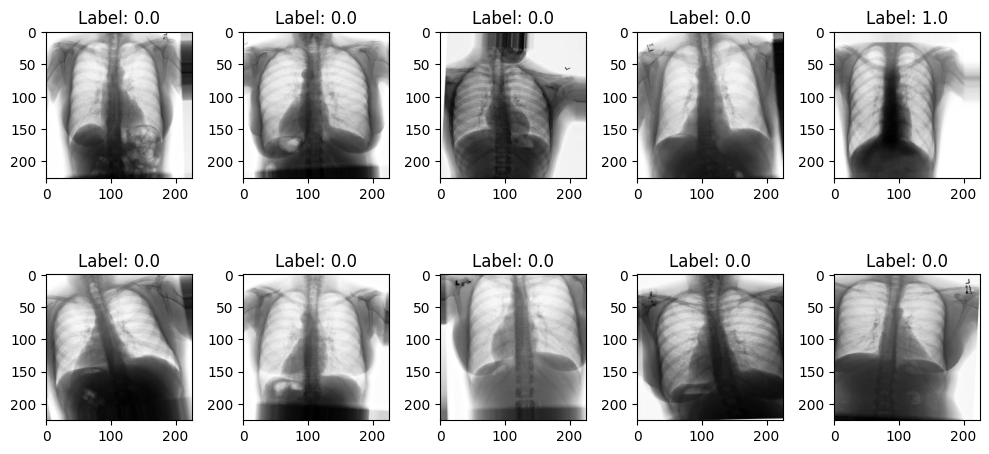

In [ ]:
#data Normalization and augmentation to generate variation in training dataset
datagen = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization= True,
                              rotation_range = cnn_config['augment']['rotation_range'],
                              width_shift_range = cnn_config['augment']['width_shift_range'],
                              height_shift_range = cnn_config['augment']['height_shift_range'],
                              zoom_range = cnn_config['augment']['zoom_range'],
                              horizontal_flip = cnn_config['augment']['horizontal_flip'])
# train image data generator                                   
image_data_generator = datagen.flow_from_dataframe(dataframe=xray_train_df,
                                                      x_col="file_path",
                                                      y_col="class_name",
                                                      class_mode="binary",
                                                      target_size=(cnn_config['data']['image_height'], cnn_config['data']['image_width']),
                                                      batch_size=cnn_config['train']['batch_size'])
plot_examples(image_data_generator)

In [ ]:
#data Normalization and augmentation to generate variation in training dataset

datagen = ImageDataGenerator(samplewise_center = cnn_config['Normalization']['samplewise_center'],
                             samplewise_std_normalization = cnn_config['Normalization']['samplewise_std_normalization'],
                                     validation_split = cnn_config['train']['valid_split'],
                                     rotation_range = cnn_config['augment']['rotation_range'],
                                     width_shift_range = cnn_config['augment']['width_shift_range'],
                                     height_shift_range = cnn_config['augment']['height_shift_range'],
                                     zoom_range = cnn_config['augment']['zoom_range'],
                                     horizontal_flip = cnn_config['augment']['horizontal_flip'])
# train image data generator                                   
train_generator = datagen.flow_from_dataframe(dataframe=xray_train_df,
                                                      x_col="file_path",
                                                      y_col="class_name",
                                                      class_mode="binary",
                                                      target_size=(cnn_config['data']['image_height'], cnn_config['data']['image_width']),
                                                      batch_size=cnn_config['train']['batch_size'],
                                                      subset='training')
# validation image data generator
validation_generator = datagen.flow_from_dataframe(dataframe=xray_train_df,
                                                           x_col="file_path",
                                                           y_col="class_name",
                                                           class_mode="binary",
                                                           target_size=(cnn_config['data']['image_height'], cnn_config['data']['image_width']),
                                                           batch_size=cnn_config['train']['batch_size'],
                                                           subset='validation')
        
cnn_model.compile(optimizer=cnn_config['train']['optimizer'](cnn_config['train']['lr']), loss='BinaryCrossentropy', metrics=cnn_config['train']['metrics'])
rlronp_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                      factor=0.9, patience=5,
                                                      verbose=1)
callbacks = [WandbMetricsLogger(), rlronp_callback]

history = cnn_model.fit(
            train_generator,
            epochs=cnn_config['train']['epochs'],
            validation_data=validation_generator,
            callbacks = callbacks
        )

Found 2688 validated image filenames belonging to 2 classes.
Found 672 validated image filenames belonging to 2 classes.
Epoch 1/50
42/42 [==============================] - 102s 2s/step - loss: 0.5182 - accuracy: 0.7746 - precision: 0.3348 - recall: 0.3422 - auc: 0.6598 - val_loss: 0.7175 - val_accuracy: 0.1592 - val_precision: 0.1592 - val_recall: 1.0000 - val_auc: 0.5441 - lr: 1.0000e-06
Epoch 2/50
42/42 [==============================] - 71s 2s/step - loss: 0.3257 - accuracy: 0.8806 - precision: 0.7426 - recall: 0.4459 - auc: 0.8260 - val_loss: 0.7229 - val_accuracy: 0.1592 - val_precision: 0.1592 - val_recall: 1.0000 - val_auc: 0.5274 - lr: 1.0000e-06
Epoch 3/50
42/42 [==============================] - 72s 2s/step - loss: 0.2891 - accuracy: 0.8936 - precision: 0.7850 - recall: 0.5077 - auc: 0.8626 - val_loss: 0.7168 - val_accuracy: 0.1830 - val_precision: 0.1579 - val_recall: 0.9533 - val_auc: 0.5604 - lr: 1.0000e-06
Epoch 4/50
42/42 [==============================] - 74s 2s/step -

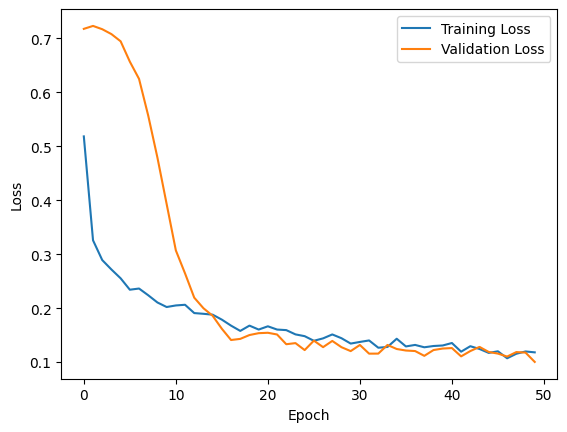

In [ ]:
# plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_prec = history.history['precision']
val_prec = history.history['val_precision']
train_rec = history.history['recall']
val_rec = history.history['val_recall']
train_auc =  history.history['auc']
val_auc = history.history['val_auc']

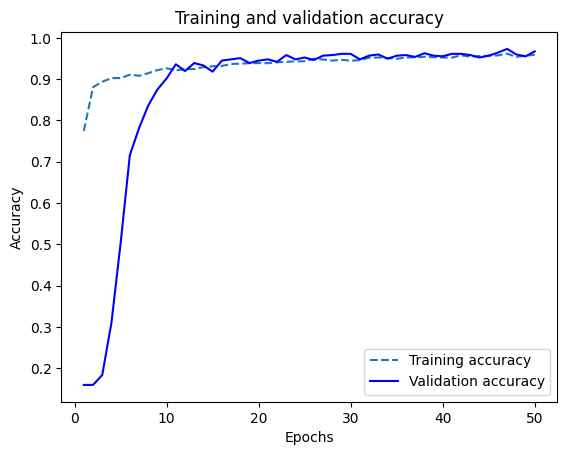

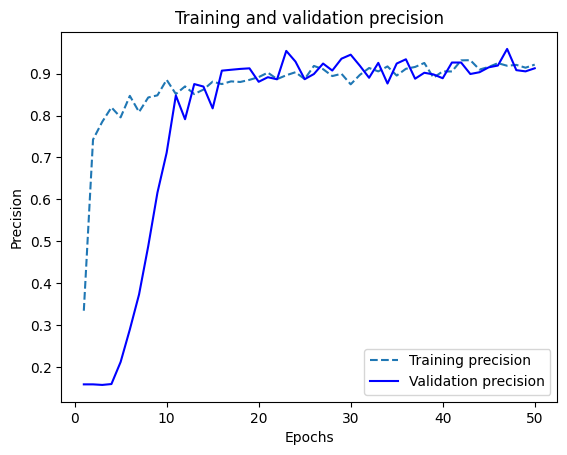

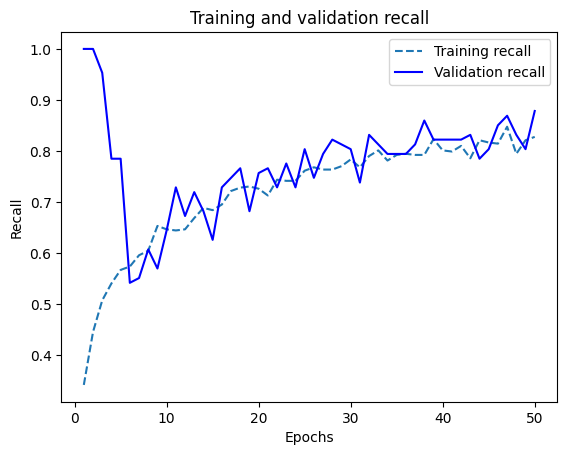

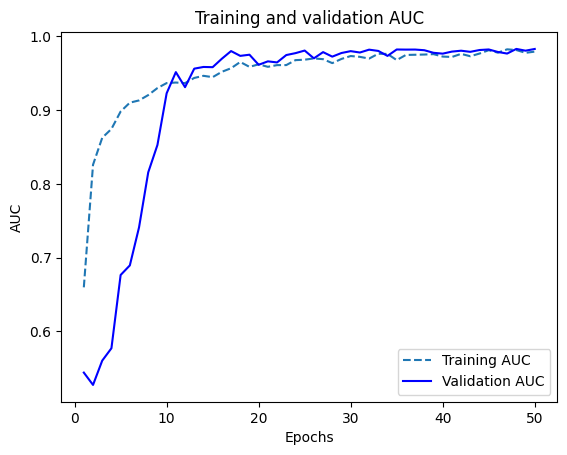

In [ ]:
epochs = range(1, len(train_acc) + 1)

# plot accuracy
plt.figure()
plt.plot(epochs, train_acc, '--', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# plot precision
plt.figure()
plt.plot(epochs, train_prec, '--', label='Training precision')
plt.plot(epochs, val_prec, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# plot recall
plt.figure()
plt.plot(epochs, train_rec, '--', label='Training recall')
plt.plot(epochs, val_rec, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# plot AUC
plt.figure()
plt.plot(epochs, train_auc, '--', label='Training AUC')
plt.plot(epochs, val_auc, 'b', label='Validation AUC')
plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.show()

In [ ]:
cnn_model.save("cnn_model.h5")

In [ ]:
# cnn_model = tf.keras.models.load_model("/content/cnn_model.h5")

# Model Evaluation

In [ ]:
x_ray_test_generator = ImageDataGenerator(samplewise_center = cnn_config['Normalization']['samplewise_center'],
                             samplewise_std_normalization = cnn_config['Normalization']['samplewise_std_normalization']).flow_from_dataframe(dataframe=xray_test_df,
                                              x_col="file_path",
                                              y_col="class_name",
                                              class_mode="binary",
                                              target_size=(cnn_config['data']['image_width'], cnn_config['data']['image_height']),
                                              batch_size=BATCH_SIZE)
y_pred = cnn_model.predict(x_ray_test_generator)
y_true = x_ray_test_generator.classes

Found 840 validated image filenames belonging to 2 classes.
14/14 [==============================] - 10s 644ms/step


## Confusion Matrix

In [ ]:
def plot_and_log_confusion_matrix(test_data_generator, y_pred_probab):
  """Plots a confusion matrix and logs it to WandB.

    Args:
        test_data_generator: A tf.keras.preprocessing.image.ImageDataGenerator instance representing the test data.
        y_pred_probab: A list of predicted probabilities.

    Returns:
        None.
    """
  y_true = test_data_generator.classes
  y_pred_labels = [1 if y_predic > 0.5 else 0 for y_predic in y_pred]
  cm = tf.math.confusion_matrix(y_true, y_pred_labels)
  cm = cm.numpy()

  fig, ax = plt.subplots(figsize=(6, 4))
 
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
  ax.set_xlabel("Predicted Label")
  ax.set_ylabel("True Label")
  ax.set_title("Confusion matrix")
  plt.subplots_adjust(left=0.1, bottom=0.2)
  wandb.log({"confusion matrix": wandb.Image(fig)})
  plt.show()

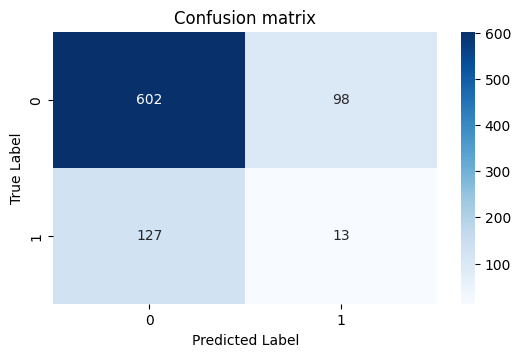

In [ ]:
plot_and_log_confusion_matrix(x_ray_test_generator, y_pred)

## Classification Report

In [ ]:
def display_and_log_clf_report(y_true, y_pred_labels):
  """Displays the classification report and logs it to WandB.

    Args:
        y_true (array-like of shape (n_samples,)): True labels.
        y_pred_labels (array-like of shape (n_samples,)): Predicted labels.

    Returns:
        None.
    """
  y_pred_labels = [1 if y_predic > 0.5 else 0 for y_predic in y_pred]
  clf_report = pd.DataFrame(classification_report(y_true, y_pred_labels, target_names=["Normal", "Tuberculosis"], output_dict=True)).transpose()
  # log report to wandb
  clf_report['class'] = clf_report.index
  clf_report = clf_report.reset_index(drop=True)
  table = wandb.Table(dataframe = clf_report, allow_mixed_types = True)
  wandb.log({'Classification Report': table})
  print(clf_report)

In [ ]:
display_and_log_clf_report(y_true, y_pred)

   precision    recall  f1-score     support         class
0   0.825789  0.860000  0.842547  700.000000        Normal
1   0.117117  0.092857  0.103586  140.000000  Tuberculosis
2   0.732143  0.732143  0.732143    0.732143      accuracy
3   0.471453  0.476429  0.473066  840.000000     macro avg
4   0.707677  0.732143  0.719387  840.000000  weighted avg


# ROC curve and AUC score

In [ ]:
def plot_and_log_roc(y_true, y_pred):
  """Plots the Receiver Operating Characteristic (ROC) curve and logs it to Weights and Biases.

  Args:
    y_true (array-like of shape (n_samples,)): True binary labels of the samples.
    y_pred (array-like of shape (n_samples,)): Predicted probability estimates of the positive class.

  Returns:
    None.
  """
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  auc_score = auc(fpr, tpr)
  fig, ax = plt.subplots()
  ax.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_score))
  ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guess')
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Receiver Operating Characteristic (ROC) Curve')
  ax.legend()
  plt.subplots_adjust(left=0.1, bottom=0.2)
  wandb.log({"ROC curve": wandb.Image(fig)})
  plt.show()

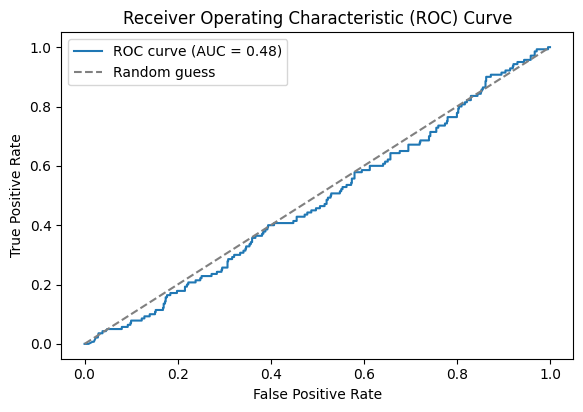

In [ ]:
plot_and_log_roc(y_true, y_pred)

# Class Activation map
Adapted from https://keras.io/examples/vision/grad_cam/

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def get_grad_cam(img, heatmap, alpha=0.005):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

In [ ]:
x_ray_test_generator.reset()
images, labels = x_ray_test_generator.next()

In [ ]:
def plot_and_log_cam(test_generator, model, last_conv_layer_name, config, pred_index=None):
  """
    Generates and displays Grad-CAM heatmaps for a batch of images from a test generator.

    Args:
    - test_generator: A generator that provides test data in batches.
    - model: A TensorFlow Keras model.
    - last_conv_layer_name: Name of the last convolutional layer in the model.
    - config: A dictionary containing configuration parameters for the model.
    - pred_index (optional): The index of the prediction to use for generating the heatmap.

    Returns: None.
    """
  images, labels = x_ray_test_generator.next()
  images, labels = test_generator.next()
  fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
  for i in range(10):
      row = i // 5
      col = i % 5
      heatmap = make_gradcam_heatmap(images[i].reshape((1,config['data']['image_height'] , config['data']['image_width'], config['data']['image_channel'])), model, last_conv_layer_name)
      img = get_grad_cam(images[1], heatmap)
      axs[row][col].imshow(img)
      axs[row][col].set_title('Label: {}'.format(labels[i]))
  plt.tight_layout()
  wandb.log({"ROC curve": wandb.Image(fig)})
  plt.show()

In [ ]:
def find_target_layer(model):
  """Finds the target layer for applying the GradCAM algorithm in a given model.
    Args:
        model: A Keras model object.
    Returns:
        The name of the target layer.
    Raises:
        ValueError: If a 4D layer cannot be found in the model.
    """
  for layer in reversed(model.layers):
      # check to see if the layer has a 4D output
      if "conv" in layer.name:
        return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
  raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

## See model.summary() to get name of last convolution layer

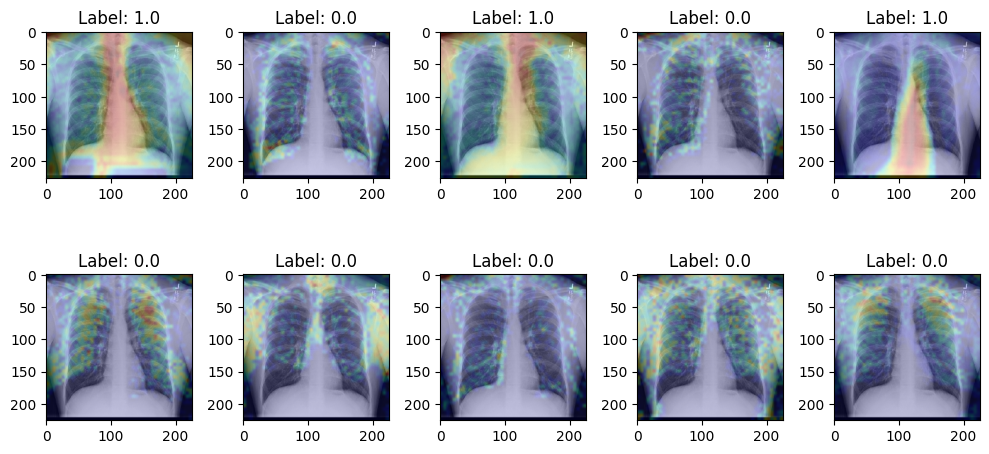

In [ ]:
# Run multiple times to visualize different outputs
last_conv_layer_name = find_target_layer(cnn_model)
plot_and_log_cam(x_ray_test_generator, cnn_model, last_conv_layer_name, cnn_config, pred_index=None)

# Chexnet (Model 2)
Using tranfer learining to leverage existing knowledge. CheXNet, is a 121-layer convolutional neural network trained on ChestX-ray14, currently the largest publicly available chest X-ray dataset,

In [ ]:
chexnet_config = {
  "data": {
        "class_names": ["Normal","Tuberculosis"],
        "image_height": 224,
        "image_width": 224,
        "image_channel": 3,
    },
    # "conv": {
    #     "filters": 32,
    #     "kernal_size": 2,
    #     "strides" : 1
    # },
    # "dense":{
    #     "units": 128,
    #     "dropout_rate": 0.2
    # },
    "Normalization" : {
        'samplewise_center' : True,
        'samplewise_std_normalization' : True
        
    },
    "augment" : {
        "rotation_range": ROTATION_RANGE,
        "width_shift_range": WIDTH_SHIFT_RANGE,
        "height_shift_range": HEIGHT_SHIFT_RANGE,
        "zoom_range": ZOOM_RANGE,
        "horizontal_flip": HORIZONTAL_FLIP
            },
    "train": {
        "batch_size": BATCH_SIZE,
        "epochs": 50,
        "optimizer": tf.keras.optimizers.Adam,
        "metrics": ['accuracy', 'Precision', 'Recall', 'AUC'],
        "test_split":TEST_SPLIT,
        "valid_split": VALIDATION_SPLIT,
        "lr": 1e-6
    }
}

# Pass the config dictionary when initializing W&B
run = wandb.init(project="tb_classification", config=chexnet_config)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
def get_chexnet_model(config):
  base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(config['data']['image_width'], config['data']['image_height'], config['data']['image_channel']))
  x = base_model.output
  # x = tf.keras.layers.Conv2D(config['conv']['filters'], config['conv']['kernal_size'], config['conv']['strides'], activation = 'relu', name = 'last_conv')(x)
  x = tf.keras.layers.Flatten()(x)
  # x = tf.keras.layers.Dense(config['dense']['units'], activation = 'relu')(x)
  # x = tf.keras.layers.Dropout(config['dense']['dropout_rate'])(x)
  output = tf.keras.layers.Dense(1, activation="sigmoid")(x)
  model = tf.keras.Model(inputs=base_model.input, outputs = output)
  return model

In [ ]:
# download pretrained weights for chexnet
!gdown 19BllaOvs2x5PLV_vlWMy4i8LapLb2j6b

Downloading...
From: https://drive.google.com/uc?id=19BllaOvs2x5PLV_vlWMy4i8LapLb2j6b
To: /content/brucechou1983_CheXNet_Keras_0.3.0_weights.h5
100% 29.1M/29.1M [00:00<00:00, 109MB/s]


In [ ]:
chexnet = get_chexnet_model(chexnet_config)
chexnet.load_weights("/content/brucechou1983_CheXNet_Keras_0.3.0_weights.h5",
                   skip_mismatch=True, by_name = True)

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
chexnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
datagen = ImageDataGenerator(samplewise_center = chexnet_config['Normalization']['samplewise_center'],
                             samplewise_std_normalization = chexnet_config['Normalization']['samplewise_std_normalization'],
                                     validation_split = chexnet_config['train']['valid_split'],
                                     rotation_range = chexnet_config['augment']['rotation_range'],
                                     width_shift_range = chexnet_config['augment']['width_shift_range'],
                                     height_shift_range = chexnet_config['augment']['height_shift_range'],
                                     zoom_range = chexnet_config['augment']['zoom_range'],
                                     horizontal_flip = chexnet_config['augment']['horizontal_flip']
                                    )
train_generator = datagen.flow_from_dataframe(dataframe=xray_train_df,
                                                      x_col="file_path",
                                                      y_col="class_name",
                                                      class_mode="binary",
                                                      target_size=(chexnet_config['data']['image_height'], chexnet_config['data']['image_width']),
                                                      batch_size=chexnet_config['train']['batch_size'],
                                                      subset='training')

validation_generator = datagen.flow_from_dataframe(dataframe=xray_train_df,
                                                           x_col="file_path",
                                                           y_col="class_name",
                                                           class_mode="binary",
                                                           target_size=(chexnet_config['data']['image_height'], chexnet_config['data']['image_width']),
                                                           batch_size=chexnet_config['train']['batch_size'],
                                                           subset='validation')
        
chexnet.compile(optimizer=chexnet_config['train']['optimizer'](chexnet_config['train']['lr']), loss=get_weighted_loss(pos_weights, neg_weights), metrics=chexnet_config['train']['metrics'])
rlronp_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                      factor=0.9, patience=5,
                                                      verbose=1)
callbacks = [WandbMetricsLogger(), rlronp_callback]
# Fit the model on the training data for this fold
history = chexnet.fit(
            train_generator,
            epochs=chexnet_config['train']['epochs'],
            validation_data=validation_generator,
            callbacks = callbacks
        )

Found 2688 validated image filenames belonging to 2 classes.
Found 672 validated image filenames belonging to 2 classes.
Epoch 1/50
42/42 [==============================] - 179s 2s/step - loss: 0.1946 - accuracy: 0.7150 - precision: 0.1826 - recall: 0.1987 - auc: 0.5622 - val_loss: 0.1873 - val_accuracy: 0.6250 - val_precision: 0.1749 - val_recall: 0.3645 - val_auc: 0.5682 - lr: 1.0000e-06
Epoch 2/50
42/42 [==============================] - 76s 2s/step - loss: 0.1917 - accuracy: 0.6417 - precision: 0.2185 - recall: 0.4371 - auc: 0.5833 - val_loss: 0.1886 - val_accuracy: 0.5744 - val_precision: 0.1769 - val_recall: 0.4579 - val_auc: 0.5612 - lr: 1.0000e-06
Epoch 3/50
42/42 [==============================] - 75s 2s/step - loss: 0.1881 - accuracy: 0.6190 - precision: 0.2257 - recall: 0.5188 - auc: 0.6185 - val_loss: 0.1842 - val_accuracy: 0.6250 - val_precision: 0.2438 - val_recall: 0.6449 - val_auc: 0.6229 - lr: 1.0000e-06
Epoch 4/50
42/42 [==============================] - 76s 2s/step -

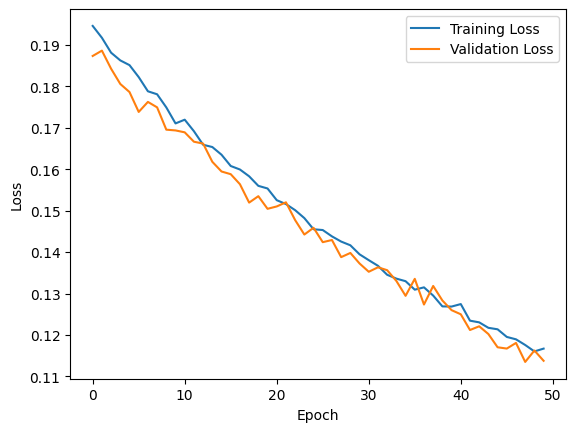

In [ ]:
# plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_prec = history.history['precision']
val_prec = history.history['val_precision']
train_rec = history.history['recall']
val_rec = history.history['val_recall']
train_auc = history.history['auc']
valid_auc = history.history['val_auc']

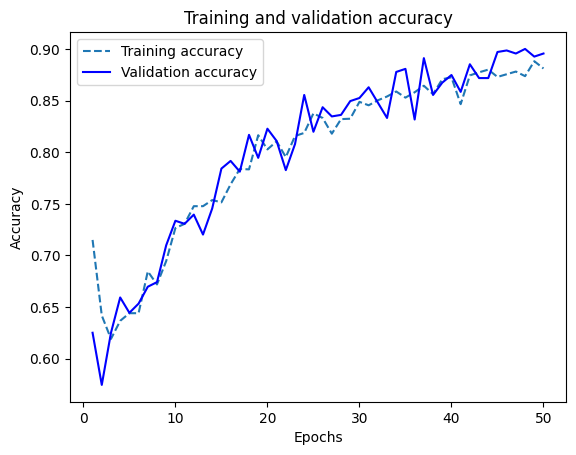

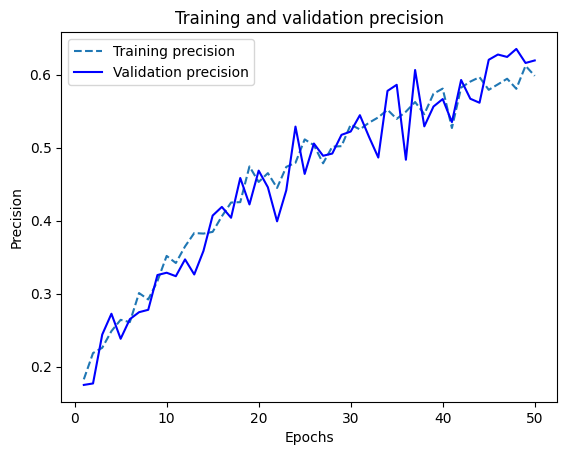

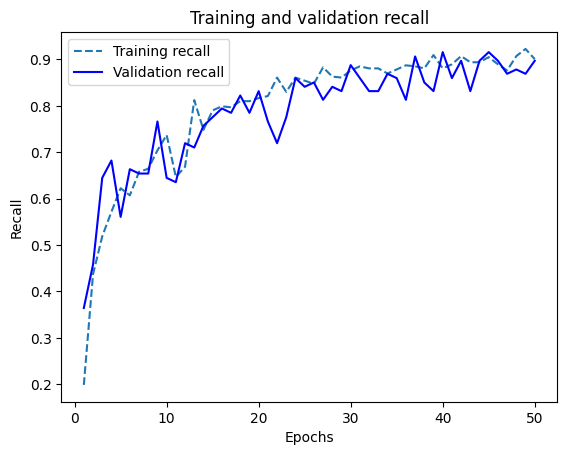

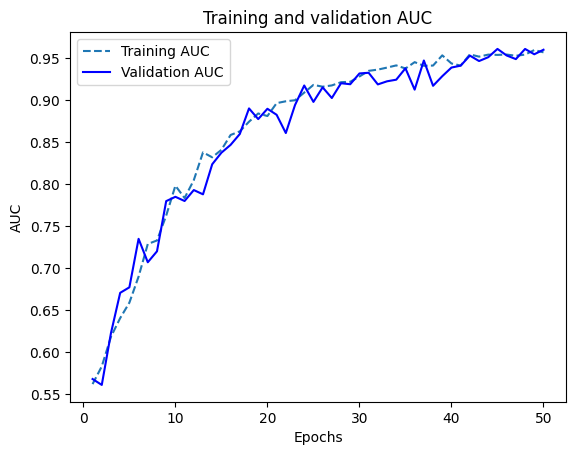

In [ ]:
epochs = range(1, len(train_acc) + 1)

# plot accuracy
plt.figure()
plt.plot(epochs, train_acc, '--', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# plot precision
plt.figure()
plt.plot(epochs, train_prec, '--', label='Training precision')
plt.plot(epochs, val_prec, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# plot recall
plt.figure()
plt.plot(epochs, train_rec, '--', label='Training recall')
plt.plot(epochs, val_rec, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# plot auc
plt.figure()
plt.plot(epochs, train_auc, '--', label='Training AUC')
plt.plot(epochs, valid_auc, 'b', label='Validation AUC')
plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.show()

In [ ]:
chexnet.save_weights("chexnet.h5")

# Evaluation

In [ ]:
x_ray_test_generator = ImageDataGenerator(samplewise_center = chexnet_config['Normalization']['samplewise_center'],
                             samplewise_std_normalization = chexnet_config['Normalization']['samplewise_std_normalization']).flow_from_dataframe(dataframe=xray_test_df,
                                              x_col="file_path",
                                              y_col="class_name",
                                              class_mode="binary",
                                              target_size=(224, 224),
                                              batch_size=32)
y_pred = chexnet.predict(x_ray_test_generator)

Found 840 validated image filenames belonging to 2 classes.
27/27 [==============================] - 12s 344ms/step


In [ ]:
y_true = x_ray_test_generator.classes

## Confusion matrix

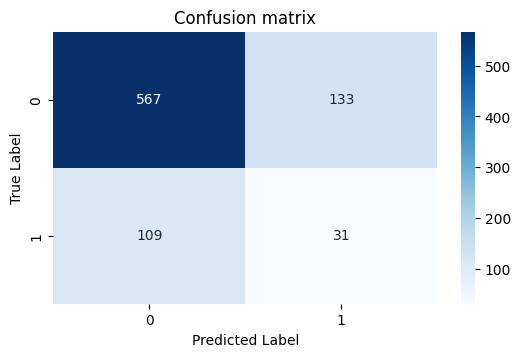

In [ ]:
plot_and_log_confusion_matrix(x_ray_test_generator, y_pred)

In [ ]:
display_and_log_clf_report(y_true, y_pred)

   precision    recall  f1-score     support         class
0   0.838757  0.810000  0.824128  700.000000        Normal
1   0.189024  0.221429  0.203947  140.000000  Tuberculosis
2   0.711905  0.711905  0.711905    0.711905      accuracy
3   0.513891  0.515714  0.514038  840.000000     macro avg
4   0.730469  0.711905  0.720764  840.000000  weighted avg


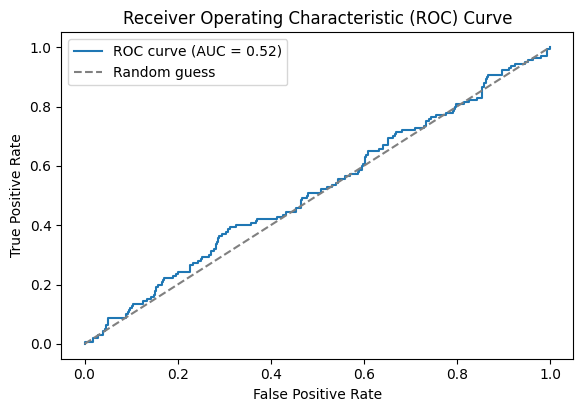

In [ ]:
plot_and_log_roc(y_true, y_pred)

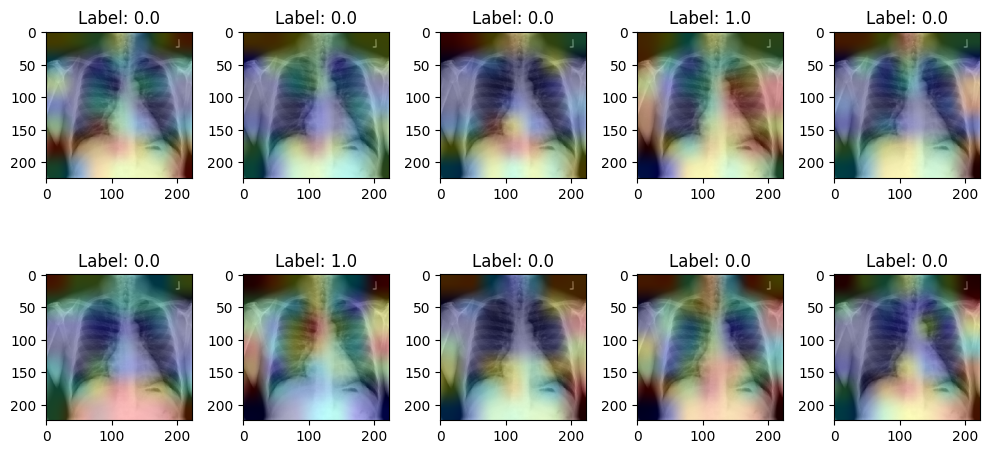

In [ ]:
last_conv_layer_name = "conv5_block16_1_conv"
plot_and_log_cam(x_ray_test_generator, chexnet, last_conv_layer_name, chexnet_config, pred_index=None)

In [ ]:
chexnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              